**Задание**

**Цель:**
Изучить применение моделей кластеризации

**Описание задания:**

В домашнем задании нужно сократить число цветов в палитре [изображения](https://www.firestock.ru/wp-content/uploads/2018/03/YArkaya-klumba-Bright-flower-bed-6000x4000-700x466.jpg). Картинку для выполнения работы можно выбрать любую, главное условие – наличие на ней разных цветов, для того, чтобы результат работы моделей был заметен.
Для выполнения работы необходимо выделить кластеры в пространстве RGB, объекты соответствуют пикселям изображения. После выделения кластеров все пиксели, отнесенные в один кластер, заполняются одним цветом. Цвет – центроид соответствующего кластера.

In [1]:
#!pip install opencv-python

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage.metrics import structural_similarity as ssim
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
import warnings
warnings.filterwarnings("ignore")

# Получите данные и загрузите их в рабочую среду (Jupyter Notebook или другую).
a) Для отображения картинки воспользуйтесь вспомогательной функцией:

In [3]:
def draw_picture(image, title, bgr=True):
    b, g, r = cv2.split(image) # по умолчанию cv2 отдает цвета в порядке BGR вместо RGB
    new_image = cv2.merge([r, g, b])
    plt.figure(figsize=(7, 5))
    plt.axis('off')
    plt.imshow(new_image)
    plt.title(title)
    plt.show()

b) Для загрузки картинки можно использовать код:

In [4]:
img = cv2.imread('Data/picture.jpg')
img.shape

(466, 700, 3)

Изменим размер изображения из-за нехватки вычислительных ресурсов.

In [5]:
img = cv2.resize(img, (350, 233))
size = img.shape
img.shape

(233, 350, 3)

In [6]:
image = img.reshape(-1, img.shape[-1]) # изменение размерности для передачи в модели кластеризации

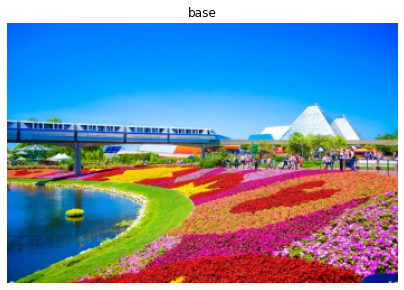

In [7]:
draw_picture(img, 'base')

# Реализуйте три модели кластеризации:

a) [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). Рассмотрите число кластеров K = 2, 5, 10, 20.

In [8]:
df = pd.DataFrame(image, columns=['R', 'G', 'B'])
k = [2, 5, 10, 20] # список чисел кластеров
ssim_kmeans = dict() # словарь для хранения метрик при различном числе кластеров
df

,R,G,B
0,255,92,0
1,253,93,0
2,253,93,0
3,254,94,0
4,255,96,0
...,...,...,...
81545,122,31,2
81546,127,96,80
81547,151,173,165
81548,157,184,177


In [9]:
def change_colores(X, colores):
    '''Функция заменяет цвета внутри кластеров на значения цветов центров кластеров(colores)'''
    for c in range(len(colores)):
        for i in range(len(X.columns[:3])):
            X.loc[X['labels'] == c, X.columns[i]] = round(colores[c][i])
    return X

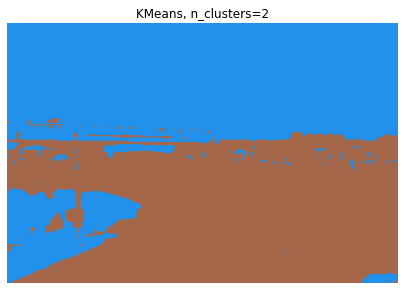

SSIM = 0.32331013749837434


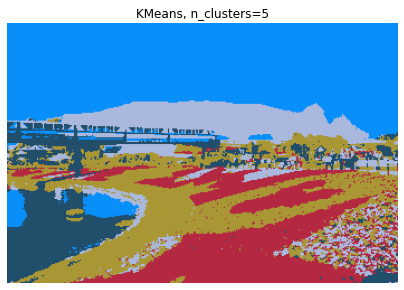

SSIM = 0.5154648791108508


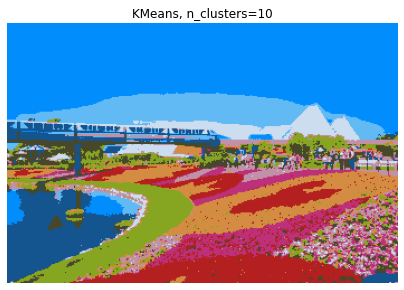

SSIM = 0.6956290358397538


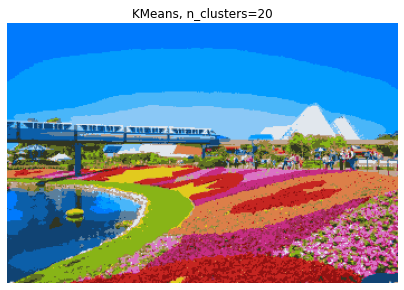

SSIM = 0.7820622050538716
CPU times: total: 57.4 s
Wall time: 7.9 s


In [10]:
%%time
for i in k:
    kmeans = KMeans(n_clusters=i, random_state=42).fit(df)
    X = df.copy()
    colores = kmeans.cluster_centers_ # цвета центров кластеров
    X['labels'] = kmeans.predict(X[['R', 'G', 'B']]) # добавляем метки кластеров
    X = change_colores(X, colores) # заменяем цвета внутри кластеров на значения цветов центров кластеров
    tmp_img = np.array(X[['R', 'G', 'B']]).reshape(size) # изменение размерности для отображения и рассчета метрики
    ssim_kmeans[f'KMeans, k={i}'] = ssim(img, tmp_img,
                                         data_range=tmp_img.max() - tmp_img.min(), channel_axis=2) # рассчет метрики SSIM
    draw_picture(tmp_img, f'KMeans, n_clusters={i}') # вывод полученного изображения
    print('SSIM =', ssim_kmeans[f'KMeans, k={i}'])

b) [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

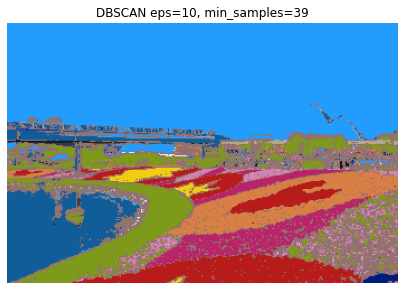

0.48923591562441837
CPU times: total: 10.9 s
Wall time: 6.54 s


In [11]:
%%time
db = DBSCAN(eps=10, min_samples=39, n_jobs=-1).fit(df)
ssim_db = dict()
X = df.copy()
labels = [i+1 for i in db.labels_] # добавляем 1, т.к. есть -1 кластер
X['labels'] = labels

colores = [ [ round(X.loc[X['labels'] == l, X.columns[i] ].mean()) for i in range(len(X.columns[:3]))]
          for l in sorted(X.labels.unique()) ] # считаем цвет кластера, как среднее всех цветов внутри кластера

X = change_colores(X, colores)
tmp_img = np.array(X[['R', 'G', 'B']]).reshape(size) # изменение размерности для отображения и рассчета метрики
ssim_db['DBSCAN_eps=10_min_samples=39'] = ssim(img, tmp_img, data_range=tmp_img.max() - tmp_img.min(),
                                             channel_axis=2) # рассчет метрики SSIM
draw_picture(tmp_img, 'DBSCAN eps=10, min_samples=39')
print(ssim_db['DBSCAN_eps=10_min_samples=39'])

c) [AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html). Рассмотрите число кластеров K = 2, 5, 10, 20.

In [13]:
%%time

connectivity = kneighbors_graph(
        df, n_neighbors=9, include_self=False, n_jobs=-1
    )

CPU times: total: 2.44 s
Wall time: 614 ms


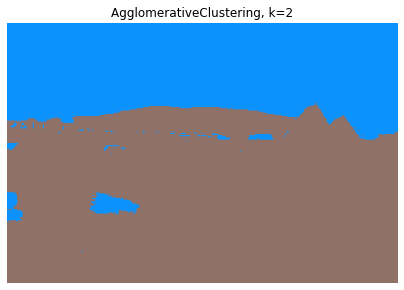

SSIM = 0.310873868939972


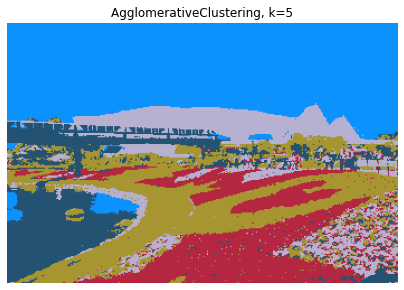

SSIM = 0.5113988340843364


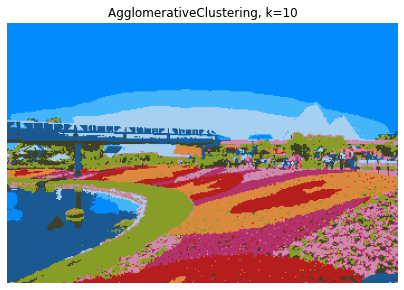

SSIM = 0.687254659707761


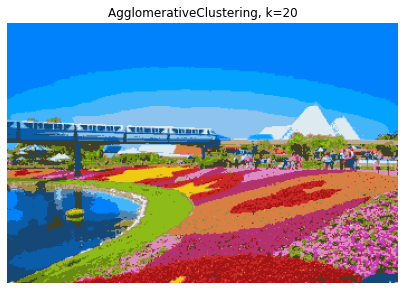

SSIM = 0.7661934912079253
CPU times: total: 5min 17s
Wall time: 3min 41s


In [14]:
%%time

ssim_ac = dict()

for i in k:
    X = df.copy()
    ac = AgglomerativeClustering(n_clusters=i, connectivity=connectivity).fit(df)
    X['labels'] = ac.labels_ # добавляем метки кластеров
    colores = [ [round(X.loc[X['labels'] == l, X.columns[j]].mean()) for j in range(len(X.columns[:3]))]
              for l in np.unique(X['labels']) ] # считаем цвет кластера, как среднее всех цветов внутри кластера

    X = change_colores(X, colores) # заменяем цвета внутри кластеров на рассчитаные значения цветов кластеров
    tmp_img = np.array(X[['R', 'G', 'B']]).reshape(size) # изменение размерности для отображения и рассчета метрики
    
    tmp_ssim = ssim(img, tmp_img, data_range=tmp_img.max() - tmp_img.min(), channel_axis=2)
    ssim_ac[f'AgglomerativeClustering, k={i}'] = tmp_ssim
    draw_picture(tmp_img, f'AgglomerativeClustering, k={i}')
    print('SSIM =', ssim_ac[f'AgglomerativeClustering, k={i}'])

# Для каждой модели оцените потери от уменьшения цветов при помощи метрики SSIM.

In [15]:
pd.DataFrame({
    'model': list(ssim_kmeans.keys()) + list(ssim_db.keys()) + list(ssim_ac.keys()),
    'SSIM': list(ssim_kmeans.values()) + list(ssim_db.values()) + list(ssim_ac.values())
})

,model,SSIM
0,"KMeans, k=2",0.323310
1,"KMeans, k=5",0.515465
2,"KMeans, k=10",0.695629
3,"KMeans, k=20",0.782062
4,DBSCAN_eps=10_min_samples=39,0.489236
5,"AgglomerativeClustering, k=2",0.310874
6,"AgglomerativeClustering, k=5",0.511399
7,"AgglomerativeClustering, k=10",0.687255
8,"AgglomerativeClustering, k=20",0.766193


# Сформулируйте выводы по проделанной работе.
a) Какая модель показала лучший результат?

Модель DBSCAN показала худший результат, так же она достаточна требовательна к вычислительным ресурсам. Модель AgglomerativeClustering показала результат чуть хуже, чем KMeans, при больших затратах вычислительных ресурсов и большем времени работы алгоритма. Наиболее подходящим алгоритмом является KMeans.